# Purpose of the notebook
To determine whether the acute kidney injury diagnosis time is a reasonable frame of reference, i.e. is it close enough to AKI detection with creatinine increase?

In [34]:
import pandas as pd
creat = pd.read_csv('../data/intermediate/creatinine_lev.csv')
creat.columns=['patientunitstayid', 'labname', 'labresult', 'labresultoffset', 'qa.aki_offset']

In [35]:
creat.sort_values(by=['patientunitstayid', 'labresultoffset'], inplace=True)

In [4]:
len(creat.patientunitstayid.unique())

2318

In [36]:
creat['prev_labresult'] = creat.groupby(['patientunitstayid'])['labresult'].shift(1)
creat['delta'] = creat['labresult'] - creat['prev_labresult']

In [37]:
creat['labresultoffset'] = pd.to_timedelta(creat['labresultoffset'], unit='minute')
creat.set_index('labresultoffset', inplace=True)
creat['creat_2day_cum'] = creat.groupby('patientunitstayid')['delta'].apply(lambda x: x.rolling('2d').sum()) 

In [38]:
creat.loc[creat['creat_2day_cum'] >= 0.3, 'AKI_reached'] = 1
creat['AKI_reached'].fillna(0, inplace=True)

In [8]:
# diagnosis explained by 0.3mg/mL increase in 48h
exp48 = creat.groupby('patientunitstayid')['AKI_reached'].sum()
print(exp48.value_counts())
exp48[exp48>1] = 1
print(exp48.sum()/len(exp48))

0.0     809
1.0     356
2.0     322
3.0     254
4.0     168
5.0     111
6.0      81
7.0      59
8.0      40
10.0     30
9.0      24
11.0     22
12.0     10
13.0      7
14.0      6
16.0      5
15.0      4
21.0      3
19.0      2
17.0      2
18.0      1
20.0      1
22.0      1
Name: AKI_reached, dtype: int64
0.6509922346850734


## 65% of diagnosis explained by 0.3md/dL increase in 2 days. However, in all cases the criterion for acute kidney injury is reached more than once before the diagnosis. This means the model could be predicting aki based on creatnine which always comes up as the top feature!

In [39]:
import math
import numpy as np
creat['creat_fold_change'] = creat['labresult']/creat['prev_labresult']
creat['creat_7day_inc'] = creat.groupby('patientunitstayid')['creat_fold_change'].apply(lambda x: x.rolling('7d').apply(np.prod))

In [40]:
creat.loc[creat['creat_7day_inc'] >= 1.5, 'AKI_reached_7d'] = 1
creat['AKI_reached_7d'].fillna(0, inplace=True)

In [13]:
exp7d = creat.groupby('patientunitstayid')['AKI_reached_7d'].sum()
exp7d[exp7d>1] = 1
exp48.sum()/len(exp48)

0.6509922346850734

In [14]:
same_pat = pd.concat([exp7d, exp48], axis=1, ignore_index=False)
len(same_pat)

2318

In [15]:
same_pat.dropna(inplace=True)
len(same_pat)

2318

In [16]:
same_pat_both = same_pat[(same_pat['AKI_reached_7d']!=0) & (same_pat['AKI_reached']!=0)]
same_pat_both

,AKI_reached_7d,AKI_reached
patientunitstayid,,
144173,1.0,1.0
144770,1.0,1.0
149913,1.0,1.0
150626,1.0,1.0
153993,1.0,1.0
...,...,...
3350977,1.0,1.0
3351357,1.0,1.0
3351749,1.0,1.0


In [17]:
len(same_pat_both)/len(same_pat)

0.45211389128559104

In [21]:
d7_only = same_pat[(same_pat['AKI_reached_7d']!=0) & (same_pat['AKI_reached']==0)]
len(d7_only)/len(same_pat)

0.0012942191544434857

In [22]:
h48_only = same_pat[(same_pat['AKI_reached_7d']==0) & (same_pat['AKI_reached']!=0)]
len(h48_only)/len(same_pat)

0.19887834339948232

* ~ 20% of diagnosis cases are identified with both 0.3mg/dL increase in 2 days and 1.5x increase in 7 days
* ~ 65% of cases are identified with 48h increase
* ~ 0.1% of cases are identified with 7 day increase 
* Concusion: 48h increase of 0.3mg/dl is a sufficient proxy for AKI onset, however, the 1.5h criterion might predict an earlier onset, increase from baseline, that the 48h metric does not consider. The latter will reduce data leakage hence the 7d criterion should be used.

In [41]:
creat.reset_index(inplace=True)
first_2d = creat[creat['AKI_reached']==1].groupby('patientunitstayid')['labresultoffset'].first()
first_2d = first_2d/pd.Timedelta('1 minute')

In [42]:
first_7d = creat[creat['AKI_reached_7d']==1].groupby('patientunitstayid')['labresultoffset'].first()
first_7d = first_7d/pd.Timedelta('1 minute')

In [43]:
aki_offset = creat.groupby('patientunitstayid')['qa.aki_offset'].first()

In [27]:
first_occur_comb = pd.concat([first_2d, first_7d, aki_offset], axis=1, ignore_index=False)
first_occur_comb.fillna(0, inplace=True)
first_occur_comb.columns = ['2d_detect', '7d_detect', 'diagnosis']
first_occur_comb = pd.concat([first_occur_comb], axis=1, ignore_index=False)
first_occur_comb.fillna(0, inplace=True)
first_occur_comb

,2d_detect,7d_detect,diagnosis
patientunitstayid,,,
142388,0.0,0.0,1757
142974,0.0,0.0,2241
143466,1759.0,0.0,7083
143518,1303.0,0.0,4468
144173,711.0,1207.0,1778
...,...,...,...
3351374,0.0,0.0,1653
3351749,207.0,1573.0,1665
3352444,16.0,16.0,2049


In [29]:
first_occur_comb.loc[first_occur_comb['2d_detect']==0, '2d_detect'] = np.nan
first_occur_comb.loc[first_occur_comb['7d_detect']==0, '7d_detect'] = np.nan

In [30]:
first_occur_comb['2d_detect_dif'] = (first_occur_comb['diagnosis'] - first_occur_comb['2d_detect'])/60
first_occur_comb['7d_detect_dif'] = (first_occur_comb['diagnosis'] - first_occur_comb['7d_detect'])/60
first_occur_comb

,2d_detect,7d_detect,diagnosis,2d_detect_dif,7d_detect_dif
patientunitstayid,,,,,
142388,NaN,NaN,1757,NaN,NaN
142974,NaN,NaN,2241,NaN,NaN
143466,1759.0,NaN,7083,88.733333,NaN
143518,1303.0,NaN,4468,52.750000,NaN
144173,711.0,1207.0,1778,17.783333,9.516667
...,...,...,...,...,...
3351374,NaN,NaN,1653,NaN,NaN
3351749,207.0,1573.0,1665,24.300000,1.533333
3352444,16.0,16.0,2049,33.883333,33.883333


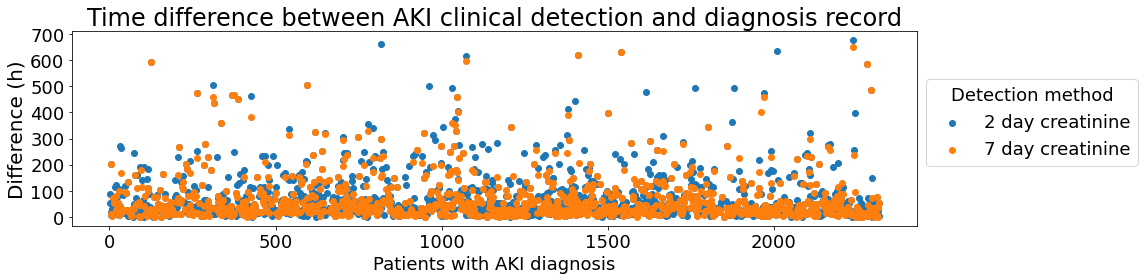

In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 4))
plt.scatter(list(range(len(first_occur_comb))), first_occur_comb['2d_detect_dif'], label='2 day creatinine')
plt.scatter(list(range(len(first_occur_comb))), first_occur_comb['7d_detect_dif'], label='7 day creatinine')
leg = plt.legend(bbox_to_anchor=(1, 0.8), fontsize=18)
leg.set_title('Detection method', prop = {'size':18})
plt.ylabel('Difference (h)', fontsize=20)
plt.title('Time difference between AKI clinical detection and diagnosis record', fontsize=24)
plt.xlabel('Patients with AKI diagnosis', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig('../images/detect_diag_offsets.png')

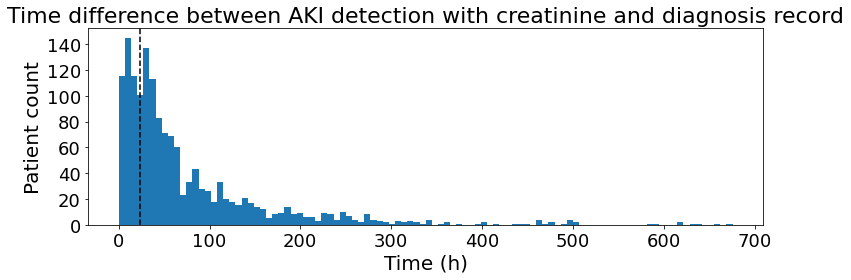

In [32]:
import seaborn as sns
plt.figure(figsize=(12, 4))
first_occur_comb['2d_detect_dif'].hist(bins=100)
plt.axvline(24, ls = '--', c='k')
plt.xlabel('Time (h)', fontsize=20)
plt.ylabel('Patient count', fontsize=20)
plt.title('Time difference between AKI detection with creatinine and diagnosis record', fontsize=22)
plt.grid(b=None)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig('../images/detect_diag_difdist.png')

In [33]:
len(first_occur_comb[first_occur_comb['2d_detect_dif']<24])/len(first_occur_comb)

0.18421052631578946

## For ~20% of pateints  time differnce between clinical detection and diagnosis being entered is < 8h. But for the rest, there is a long tail of many days. Based on this data I should use the KDIGO definition onset and not diagnosis time. Note, I will not use aki detection based on urine since teh data is very spotty

# The rest of the notebooks is not used since urine measurments are missing for ~80% of patients and since a single missed measurement for a patient will result a false positive detection.

In [1]:
urine = pd.read_csv('../data/intermediate/urine_out.csv')
urine.columns = ['patientunitstayid', 'intakeoutputoffset', 'cellvaluenumeric', 'celllabel']
urine.head()

In [2]:
urine.sort_values(by=['patientunitstayid', 'intakeoutputoffset', 'celllabel'])
urine.head()

In [47]:
len(urine.patientunitstayid.unique())

2088

In [3]:
urine.set_index(['patientunitstayid', 'intakeoutputoffset', 'celllabel'], inplace=True)
urine.head()

In [4]:
urine = urine.unstack(level=2)
urine.head()

In [5]:
urine.columns = urine.columns.droplevel()
urine.columns = ['Bodyweight (kg)', 'Urine (mL)']
urine.head()

In [6]:
#urine.reset_index(inplace=True)
urine['prev_intakeoutput'] = urine.groupby(['patientunitstayid'])['intakeoutputoffset'].shift(1)
urine.fillna(0, inplace=True)
urine['time_delta'] = urine['intakeoutputoffset'] - urine['prev_intakeoutput']
urine.head()

In [7]:
urine['ml/kg/h'] = (urine['Urine (mL)']/urine['Bodyweight (kg)']) / (urine['time_delta'].abs()/60)
urine['intakeoutputoffset'] = pd.to_timedelta(urine['intakeoutputoffset'], unit='minute')
urine.set_index('intakeoutputoffset', inplace=True)
urine['urine_6h_ave'] = urine.groupby('patientunitstayid')['ml/kg/h'].apply(lambda x: x.rolling('6h').mean()) 
urine.head()

In [55]:
urine_nonull = urine.dropna()
urine_nonull['ml/kg/h'].isna().sum()

0

In [8]:
urine_nonull

In [9]:
pd.set_option('mode.chained_assignment', None)
urine_nonull.loc[urine_nonull['urine_6h_ave'] < 0.5, 'AKI_reached_6h'] = 1
urine_nonull['AKI_reached_6h'].fillna(0, inplace=True)
urine_nonull.head()

In [59]:
urine_nonull.reset_index(inplace=True)
urine_6h = urine_nonull[urine_nonull['AKI_reached_6h']==1].groupby('patientunitstayid')['intakeoutputoffset'].first()
urine_6h = urine_6h/pd.Timedelta('1 minute')
urine_6h

patientunitstayid
142388       -86.0
142974      -233.0
143466        60.0
143518      -112.0
144173      -403.0
            ...   
3351374     -838.0
3351749     -102.0
3352444    -3244.0
3353194     -155.0
3353197   -12601.0
Name: intakeoutputoffset, Length: 1285, dtype: float64

In [60]:
exp6h = urine_nonull.groupby('patientunitstayid')['AKI_reached_6h'].sum()
exp6h.value_counts()

1.0      234
2.0      198
3.0      173
4.0      137
5.0      105
6.0       95
0.0       81
7.0       60
8.0       37
9.0       34
10.0      29
12.0      26
11.0      22
13.0      15
15.0      12
18.0      12
14.0      12
17.0      10
16.0      10
20.0       9
24.0       8
22.0       5
19.0       4
26.0       4
27.0       4
33.0       3
21.0       3
23.0       3
31.0       3
44.0       2
25.0       2
47.0       2
34.0       2
35.0       1
42.0       1
57.0       1
30.0       1
41.0       1
39.0       1
38.0       1
76.0       1
36.0       1
156.0      1
Name: AKI_reached_6h, dtype: int64

In [61]:
same_pat = pd.concat([same_pat, exp6h], axis=1, ignore_index=False)
same_pat

,AKI_reached_7d,AKI_reached,AKI_reached_6h
patientunitstayid,,,
142388,0.0,0.0,3.0
142974,0.0,0.0,3.0
143466,0.0,1.0,5.0
143518,0.0,1.0,10.0
144173,3.0,1.0,1.0
...,...,...,...
3351374,0.0,0.0,5.0
3351749,1.0,1.0,11.0
3352444,1.0,1.0,2.0


In [62]:
no_simp = same_pat[(same_pat['AKI_reached_7d']==0) | (same_pat['AKI_reached_7d'].isna())]
print(len(same_pat))
print(len(no_simp))

2321
1270


In [101]:
no_simp = no_simp[(no_simp['AKI_reached']==0) | (no_simp['AKI_reached'].isna())]
print(len(no_simp))

671


In [63]:
no_simp = no_simp[(no_simp['AKI_reached_6h']==0) | (no_simp['AKI_reached_6h'].isna())]
print(len(no_simp))

581


In [64]:
no_simp

,AKI_reached_7d,AKI_reached,AKI_reached_6h
patientunitstayid,,,
180463,0.0,0.0,NaN
212352,0.0,0.0,NaN
249893,0.0,0.0,0.0
255486,0.0,0.0,0.0
266992,0.0,0.0,0.0
...,...,...,...
3346657,0.0,0.0,NaN
3349087,0.0,1.0,0.0
3349239,0.0,0.0,NaN
